## Calibración de Curvas

In [1]:
#Librerías
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime, time,date,timedelta

In [2]:
# Convert dateTime of python in excel serial number
def datetime_to_excel_date(date1):
    temp = datetime(1899, 12, 30)    # Note, not 31st Dec but 30th!
    delta = date1 - temp
    return int(float(delta.days) + (float(delta.seconds) / 86400))


def get_date_from_tenor(date, tenor):
    if tenor[-1].lower() == "m":
        return date + int(tenor[:-1]) * 30
    elif tenor[-1].lower() == "y":
        return date + int(tenor[:-1]) * 360
    elif tenor[-1].lower() == "d":
        return date + int(tenor[:-1])

In [3]:
## ejemplo de cómo funciona el interpolador

x = [1,2,3]

y = [5,12,19]

interpolador = interp1d(x, y, kind="linear", fill_value="extrapolate")

interpolador(1.5)

array(8.5)

In [4]:
#OBJETO CURVA

class IRCurve:
    # t es un vector de tiempos (vistos como números de serie de excel)
    # df es el vector de factores de descuento
    def __init__(self, t, df):
        self.t = t.copy()
        self.log_df = np.log(df)
        self.interp = interp1d(self.t, self.log_df, kind ='linear', fill_value="extrapolate")  # es una función

    # ti es un número
    def discount_factor(self, ti):
        aux_ln_disc = self.interp(ti)
        return np.exp(aux_ln_disc)

    ## date_from < date_to
    def discount_factor_fwd(self, date_from, date_to):
        return self.discount_factor(date_to) / self.discount_factor(date_from)

    def fwd_rate(self, date_from, date_to):
        Delta = (date_to - date_from)/360
        libor = (self.discount_factor(date_from)/self.discount_factor(date_to) - 1) / Delta
        return libor

**CETES**

In [5]:
# inputs de mercado
value_date = datetime_to_excel_date(datetime(2024, 12, 3))

tenors = ["1M", "3M", "6M", "12M", "24M"]
mkt_rate = np.array([0.099, 0.0988, 0.0999, 0.102, 0.1008])


(d_1 - d_2).days / 360

(d_1 - d_2) / 460

In [6]:
# creamos nuestra curva con la solución analítica
end_dates = [get_date_from_tenor(value_date, tenor) for tenor in tenors]

deltas = [(t - value_date) / 360 for t in end_dates]

disc_factor = [1/(1+r*t) for (r,t) in zip(mkt_rate, deltas)]

print(end_dates, disc_factor)


[45659, 45719, 45809, 45989, 46349] [0.9918175055789734, 0.9758953840148337, 0.9524263060145722, 0.9074410163339383, 0.8322237017310253]


In [7]:
depo_curve = IRCurve([value_date] + end_dates, [1] + disc_factor)

depo_curve.discount_factor(46169)

0.8690189420927451

In [8]:
# aquí pdemos ver los factores de descuento que hemos calculado
list(zip(end_dates, disc_factor))

[(45659, 0.9918175055789734),
 (45719, 0.9758953840148337),
 (45809, 0.9524263060145722),
 (45989, 0.9074410163339383),
 (46349, 0.8322237017310253)]

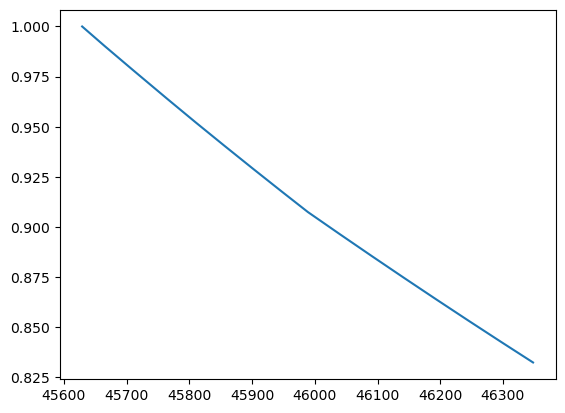

In [9]:
aux_dt = np.arange(value_date, end_dates[-1], 1)
aux_df = [depo_curve.discount_factor(t) for t in aux_dt]

plt.plot(aux_dt, aux_df)

In [10]:
## calcular cete a 18M
vencimiento = get_date_from_tenor(value_date, "18M")

delta_18M = (vencimiento - value_date) /360
disc_18M = depo_curve.discount_factor(vencimiento)
precio = round(10 * disc_18M, 7)

rate_18M = (1/ disc_18M - 1) / delta_18M

print(f"precio =  {precio} \ntasa = {round(100*rate_18M, 4)}")

precio =  8.6901894 
tasa = 10.0482


## **Calibración de la curva**

* Para hacer optimización o búsqueda de ceros, tenemos que definir clases para crear los instrumentos.

* Cada clase debe tener un método en común (implicit_rate) el cual depende de la curva que queremos calibrar.

* Con ese método y una curva que funciona como incógnita, podemos calcular la tasa implícita de modelo. El objetivo es obtener la curva que nos recupera el vector de tasas de mercado.

In [11]:
class Depo:
    def __init__(self, start_date, tenor):
        self.start_date = start_date
        self.end_date = get_date_from_tenor(start_date, tenor)
    
    # tasa par de mercado
    def implicit_rate(self, estimation_curve):
        libor = estimation_curve.fwd_rate(self.start_date, self.end_date)
        return libor

    def mty_date(self):
        return self.end_date


In [12]:
# en caso de querer usar otros instruemtnos, basta con definir su clase

# swap fijo vs flotante
class Swap:
    def __init__(self, start_date, tenor, freq, curva_est):
    
    ## tasa par del swap
    def implicit_rate
    
    def mty_date(self):
        return self.end_date

IndentationError: expected an indented block after function definition on line 5 (2969211102.py, line 8)

In [13]:
# inputs de mercado
value_date = datetime_to_excel_date(datetime(2024, 12, 3))

tenors = ["1M", "3M", "6M", "12M", "24M"]
mkt_rates = np.array([0.099, 0.0988, 0.0999, 0.102, 0.1008])

In [14]:
# creamos nuestros instrumentos
instruments = [Depo(value_date, T) for T in tenors]

instruments

In [15]:
# calculamos las fechas de vencimiento
dates = [x.mty_date() for x in instruments]
dates

[45659, 45719, 45809, 45989, 46349]

In [16]:
#calculamos una semilla de factores de descuento
seed = [np.exp(-(t-value_date) * r / 365) for (r,t) in zip(mkt_rates, dates)]
print(seed)


[0.9918960293616431, 0.9759327058838598, 0.9519281179232552, 0.9042922009070309, 0.8196823792286387]


In [17]:
# con lo anterior podemos construir una curva
example_curve = IRCurve([value_date] + dates, [1] + seed)

# con la curva anterior podemos calcular las tasas implícitas para cada depósito
[x.implicit_rate(example_curve) for x in instruments]

[0.09804217859695363,
 0.09864325263838136,
 0.10099897496802468,
 0.10583724928399407,
 0.10999237347339896]

In [ ]:
mkt_rates = np.array([0.099, 0.0988, 0.0999, 0.102, 0.1008])

Como vemos en la celda anterior, las tasas de modelo no son iguales a las tasas de mercado.

En la siguiente celda hacemos un algoritmo para mover la curva y recuperar las tasas de mercado:

In [18]:
def zero_function(zeros):
    #dates = [x.mty_date() for x in instruments]
    #print(len(dates), len(zeros))
    aux_curve = IRCurve([value_date] + dates, [1] + list(zeros))
    
    ## reevaluamos cada uno de los instrumentos dentro de la cartera
    model_quotes = [x.implicit_rate(aux_curve) for x in instruments]
    
    error = [1_000_000 * abs(x - y) for (x,y) in zip(model_quotes, mkt_rates)]
    return error

In [19]:
# aquí podemos ver el error que estamos cometiendo en recuperar la tasa de cada instrumento
zero_function(seed)

[957.8214030463716,
 156.74736161863655,
 1098.9749680246769,
 3837.249283994079,
 9192.373473398962]

In [67]:
# comprobación para el primer caso
1_000_000 * abs(0.09804217859695363 - 0.099)

957.8214030463716

In [20]:
# calculamos el vector de zeros que recupera los precios de mercado

from scipy import optimize
zeros_sol = optimize.newton_krylov(zero_function, seed)
zeros_sol


array([0.99181751, 0.97589538, 0.95242631, 0.90744102, 0.8322237 ])

In [21]:
# ... y con este vector construimos una curva
optim_curva = IRCurve([value_date] + dates, [1] + list(zeros_sol))

# con la curva optimizada, volvemos a calcular tasas implícitas
[x.implicit_rate(optim_curva) for x in instruments]

[0.09900000000043008,
 0.09879999999977152,
 0.09990000000007893,
 0.10200000000005649,
 0.10080000000000089]

In [22]:
# se parace bastante a las tasas de mercado:
mkt_rates

array([0.099 , 0.0988, 0.0999, 0.102 , 0.1008])

In [23]:
#podemos medir el error
# dividimos por 1 millón porque así escalamos el error en la función objetivo
[x/1_000_000 for x in zero_function(zeros_sol)]

[4.3007264416417e-13,
 2.284838984678572e-13,
 7.892297926304082e-14,
 5.6496474165612653e-14,
 8.881784197001252e-16]

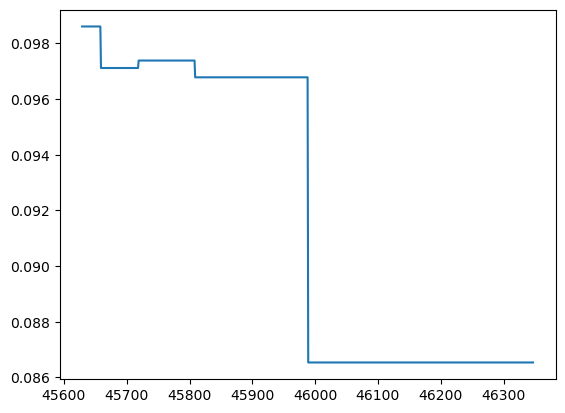

In [24]:
## efecto de la interpolación que estoy usando para construir curvas
# gráfica de la tasa diaria instantánea

## con una interpolación log-lineal, estamos dejando constante a tramos la tasa ON
fechas = np.arange(value_date, end_dates[-1], 1)
daily_fwd = [optim_curva.fwd_rate(t_1, t_2) for (t_1, t_2) in zip(fechas[:-1], fechas[1:]) ]

plt.plot(fechas[:-1], daily_fwd);